In [1]:
from pymatgen.core.surface import Slab
from pymatgen import Structure, Specie, Element
from pymatgen.core.sites import PeriodicSite
from pymatgen.io.vasp.outputs import Vasprun
import os
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('once')

## Matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.figsize'] = (7.0,6.0)
mpl.rcParams.update({'font.size': 18})


def slab_from_file(hkl, filename):
    """
    reads in structure from the file and returns slab object.
    Args:
         hkl (tuple): miller index of the slab in the input file.
         filename (str): structure file in any format
                   supported by pymatgen
    Returns:
         Slab object
    """
    slab_input = Structure.from_file(filename)
    return Slab(slab_input.lattice,
                slab_input.species_and_occu,
                slab_input.frac_coords,
                hkl,
                Structure.from_sites(slab_input, to_unit_cell=True),
                shift=0,
                scale_factor=np.eye(3, dtype=np.int),
                site_properties=slab_input.site_properties)

def parse_fols(hkl, bulk_per_atom):
    """
    parses the convergence folders to get the surface energy, total energy, energy per atom and time taken for each slab/vacuum thickness combination
    Args:
        hkl (tuple): miller index of the slab
        bulk_per_atom (float): bulk energy per atom from a converged run

    Returns:
        .csv file
    """

    d = []
    hkl_sorted = ''.join(map(str, hkl))

    for root, fols, files in os.walk('.'):
        for fol in fols:
            if not any([fol=='setup', fol==root, fol=='.ipynb_checkpoints']):
                path = os.path.join(root, fol)
                psc = '{}/POSCAR'.format(path)
                vsp = '{}/vasprun.xml'.format(path)

                #instantiate structure, slab and vasprun objects
                structure = Structure.from_file(psc)
                vasprun = Vasprun(vsp)
                slab = slab_from_file(hkl, psc)

                #extract the data
                area = slab.surface_area
                atoms = len(structure.atomic_numbers)
                slab_energy = vasprun.final_energy
                energy_per_atom = slab_energy / atoms
                surf_energy = (slab_energy - bulk_per_atom * atoms)/(2 * area) * 16.02

                #name of fol has to be ./slabthickness_vacthickness_index
                slab_vac_index = fol.split('_')

                #reads the outcar to get the time taken
                with open('{}/OUTCAR'.format(path), 'r') as otc:
                    lines = list(otc)
                    line = lines[-8].split(':')


                d.append({'slab_thickness': slab_vac_index[0],
                          'vac_thickness': slab_vac_index[1],
                          'slab_index': slab_vac_index[2],
                          'surface_energy': surf_energy,
                          'slab_toten': slab_energy,
                          'slab_per_atom': energy_per_atom,
                          'time_taken': line[1].strip()})


    df = pd.DataFrame(d)
    df.to_csv('{}_data.csv'.format(hkl_sorted), index=False)

def plot_surface_energy(hkl, time_taken=True, dpi=300, **kwargs):
    """
    does what it says on the tin - reads the csv, makes the plot of surface energy
    NB does not account for multiple terminations
    Args:
        hkl (tuple): miller index
        time_taken (bool): whether it shows the time taken for calculation to finish on the graph, default=True
        dpi (int): dots per inch, default=300
    Returns:
        hkl_energy_per_atom_conv.png
    """

    hkl_sorted = ''.join(map(str, hkl))
    df = pd.read_csv('{}_data.csv'.format(hkl_sorted))

    #get the energy values
    df2 = df.pivot(index='slab_thickness', columns='vac_thickness', values='surface_energy')
    vals = df2.to_numpy()

    #get the time values
    df3 = df.pivot(index='slab_thickness', columns='vac_thickness', values='time_taken')
    times = df3.to_numpy()

    #set up axes and im
    ax = plt.gca()
    ax.set_yticks(list(range(len(df2.index))))
    ax.set_yticklabels(df2.columns)
    ax.set_xticks(list(range(len(df2.columns))))
    ax.set_xticklabels(df2.columns)
    im = plt.imshow(vals, cmap='Wistia', interpolation='mitchell')


    #add the energy per atom value labels
    for i in range(len(df2.index)):
        for j in range(len(df2.columns)):
            for val in vals:
                text = ax.text(j, i, f"{vals[i, j]: .3f}", ha="center", va="bottom", color="black")

    #add the time taken labels
    if time_taken is not False:
        for i in range(len(df2.index)):
            for j in range(len(df2.columns)):
                for time in vals:
                    text = ax.text(j, i, (f"{times[i, j]: .0f}"+' s'), ha="center", va="top", color="black")

    #invert axis and plot the titles
    ax.invert_yaxis()
    plt.ylabel('slab thickness')
    plt.xlabel('vacuum thickness')
    plt.title('{} surface energies'.format(hkl))

    #show the colour bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('surface energy')
    plt.savefig('{}_surface_energy_conv.png'.format(hkl_sorted), dpi=dpi, bbox_inches='tight')
    plt.show()



def plot_energy_per_atom(hkl, time_taken=True, dpi=300, **kwargs):
    """
    does what it says on the tin - reads the csv, makes the plot of energy per atom
    NB does not account for multiple terminations
    Args:
        hkl (tuple): miller index
        time_taken (bool): whether it shows the time taken for calculation to finish on the graph, default=True
        dpi (int): dots per inch, default=300
    Returns:
        hkl_energy_per_atom_conv.png
    """

    hkl_sorted = ''.join(map(str, hkl))
    df = pd.read_csv('{}_data.csv'.format(hkl_sorted))

    #get the energy values
    df2 = df.pivot(index='slab_thickness', columns='vac_thickness', values='slab_per_atom')
    vals = df2.to_numpy()

    #get the time values
    df3 = df.pivot(index='slab_thickness', columns='vac_thickness', values='time_taken')
    times = df3.to_numpy()

    #set up axes and im
    ax = plt.gca()
    ax.set_yticks(list(range(len(df2.index))))
    ax.set_yticklabels(df2.columns)
    ax.set_xticks(list(range(len(df2.columns))))
    ax.set_xticklabels(df2.columns)
    im = plt.imshow(vals, cmap='Wistia', interpolation='mitchell')

    #add the energy per atom value labels
    for i in range(len(df2.index)):
        for j in range(len(df2.columns)):
            for val in vals:
                text = ax.text(j, i, f"{vals[i, j]: .3f}", ha="center", va="bottom", color="black")

    #add the time taken labels
    if time_taken is not False:
        for i in range(len(df2.index)):
            for j in range(len(df2.columns)):
                for time in vals:
                    text = ax.text(j, i, (f"{times[i, j]: .0f}"+' s'), ha="center", va="top", color="black")

    #invert axis and plot the titles
    ax.invert_yaxis()
    plt.ylabel('slab thickness')
    plt.xlabel('vacuum thickness')
    plt.title('{} energies per atom'.format(hkl))

    #show the colour bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('energy per atom')
    plt.savefig('{}_energy_per_atom_conv.png'.format(hkl_sorted), dpi=dpi, bbox_inches='tight')
    plt.show()


assuming the folders were made with slabby stabby we can easily parse them and extract the surface energy, total energy, energy per atom and time elapsed of each slab/vacuum thickness combination; this is done by calling the function 
^ the code cell above has all the functions i can't figure out how to import them ?? 

In [10]:
parse_fols(hkl=(0,0,1), bulk_per_atom=-8.83099767)

/anaconda3/lib/python3.7/site-packages/pymatgen/io/vasp/outputs.py:155: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn('Float overflow (*******) encountered in vasprun')


visualise the convergence of surface energy

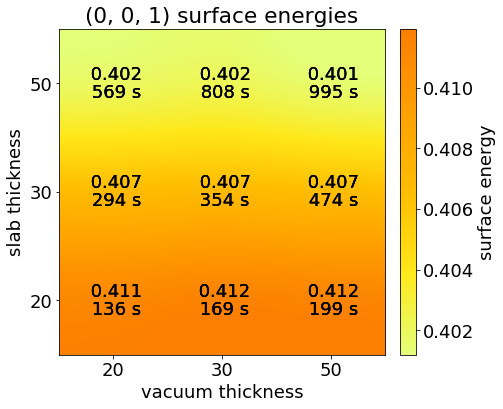

In [2]:
plot_surface_energy(hkl=(0,0,1))

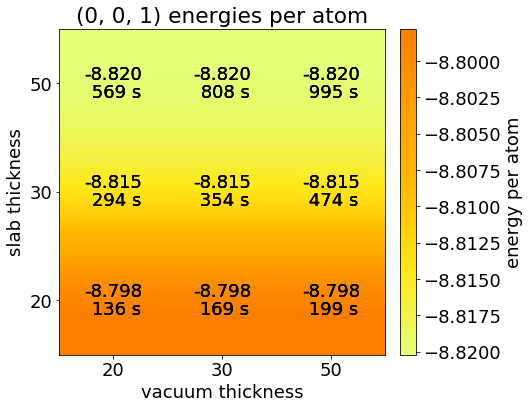

In [3]:
plot_energy_per_atom(hkl=(0,0,1))